# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [59]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load data

In [4]:
#variables related to loading
path = "M06_th45/"
path_fields = "M06_th45/"
path_particles = "M06_th45/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
numframe = 2000


In [5]:
#load fields
dfields = dh5.field_loader(path=path_fields,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/data_h5.py:170: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [7]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, dfields['ex_xx'][0], dfields['ex_xx'][-1], dfields['ex_yy'][0], dfields['ex_yy'][1], dfields['ex_zz'][0], dfields['ex_zz'][1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  52.96006107330322


In [8]:
dparticles

{'p1': array([ 4.958004 , -7.1568456,  5.381101 , ..., -5.7104936, -6.593224 ,
         3.148276 ], dtype=float32),
 'p2': array([-1.6982627 ,  0.05796169, -1.703056  , ...,  1.1640663 ,
         1.2820272 , -3.1062458 ], dtype=float32),
 'p3': array([ 0.54655933,  5.2125998 ,  0.7653251 , ...,  0.19005348,
        -0.48851827, 16.161015  ], dtype=float32),
 'x1': array([24.021744, 24.357712, 24.244284, ..., 71.84814 , 71.81326 ,
        70.47518 ], dtype=float32),
 'x2': array([0.13786893, 0.32540363, 0.14250061, ..., 0.19027692, 0.20542178,
        0.1755735 ], dtype=float32),
 'x3': array([0.3745106 , 0.25591445, 0.29925483, ..., 0.34443223, 0.1726036 ,
        0.33587795], dtype=float32)}

In [9]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

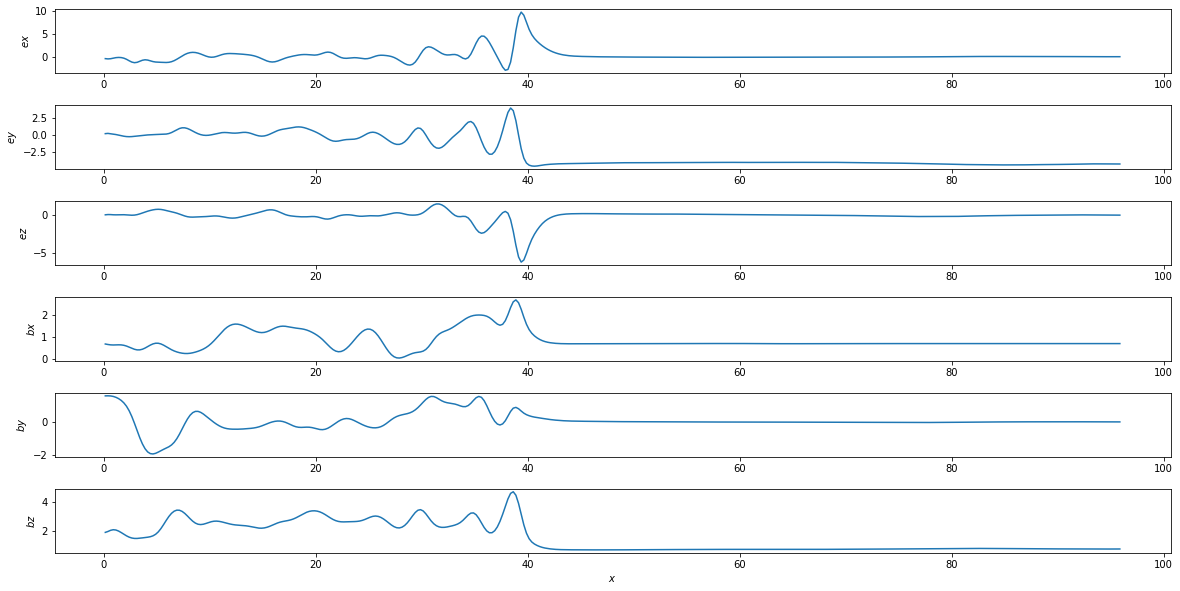

In [12]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

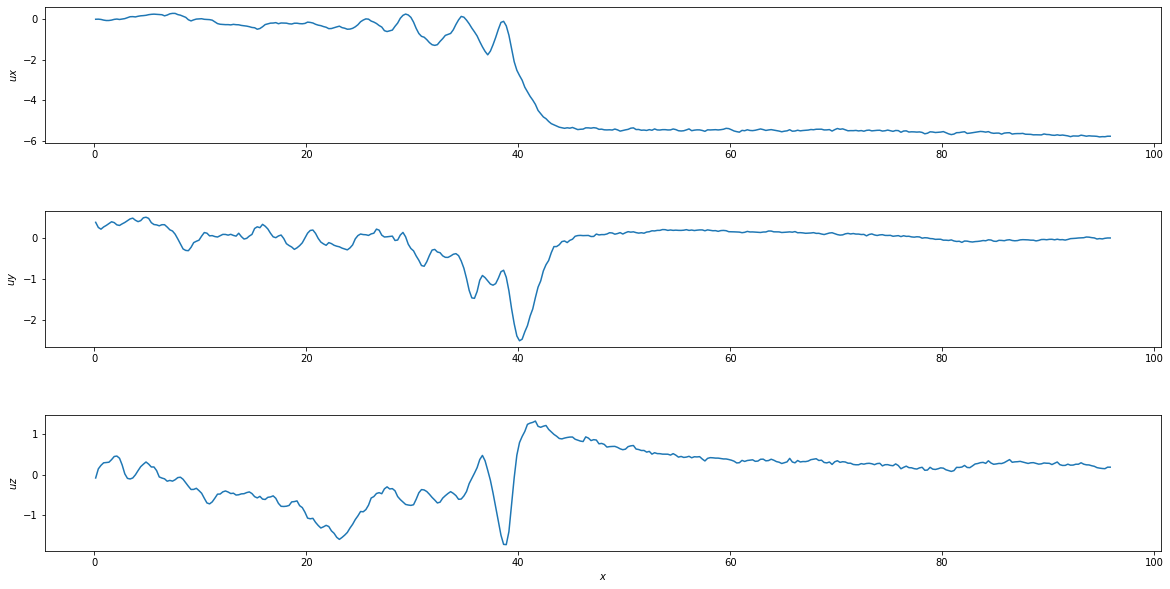

In [13]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

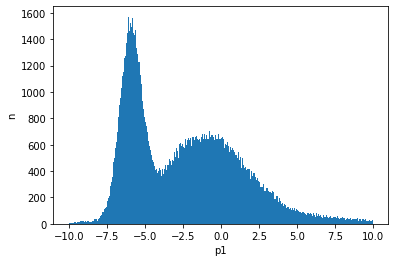

<Figure size 432x288 with 0 Axes>

In [15]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., dfields['ex_xx'][0], dfields['ex_xx'][-1],dfields['ex_yy'][0], dfields['ex_yy'][-1])

### Compute Shock Vel and Lorentz transform fields

In [19]:
#pick some point in the middle of the simulation and plot it as a function of time
all_dfields = dh5.all_dfield_loader(path=path_fields, verbose=False)


/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/data_h5.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [20]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


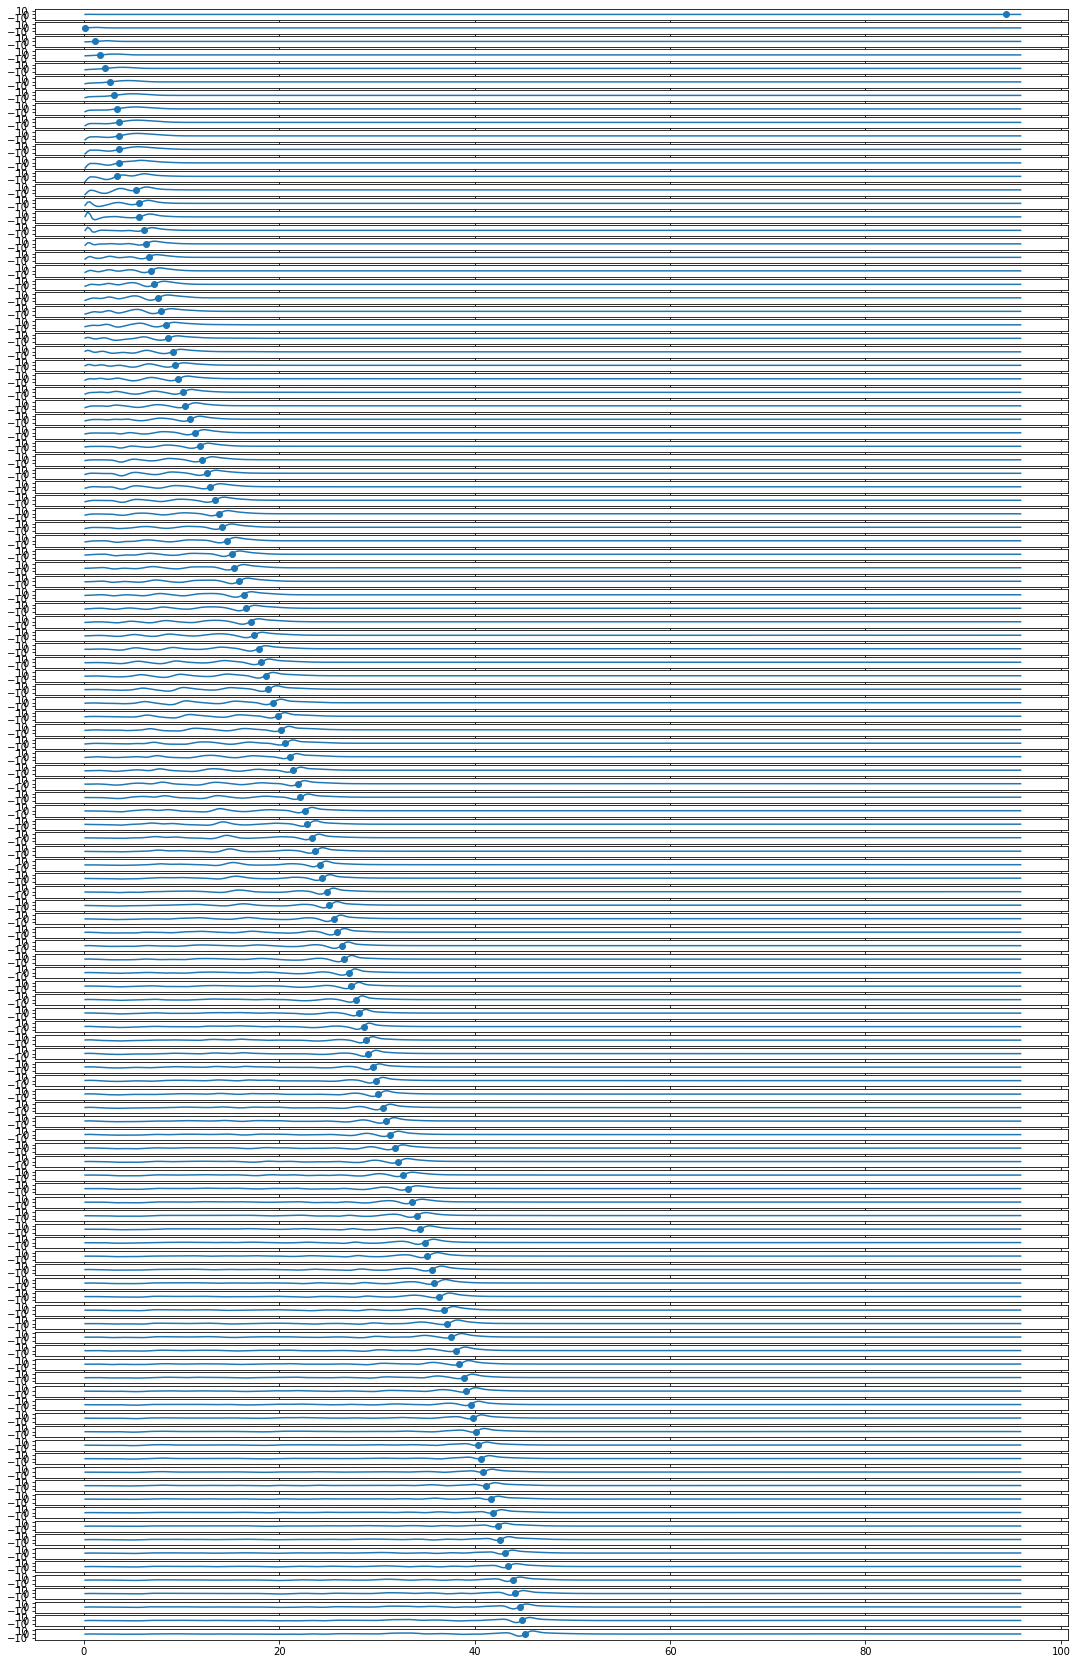

In [24]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [26]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

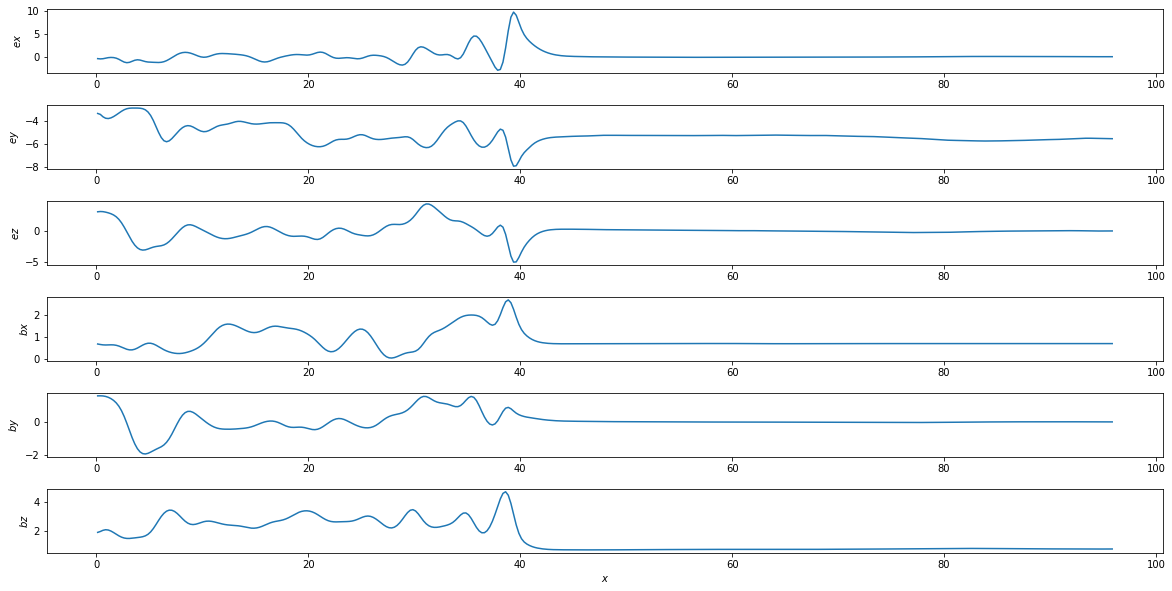

In [27]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

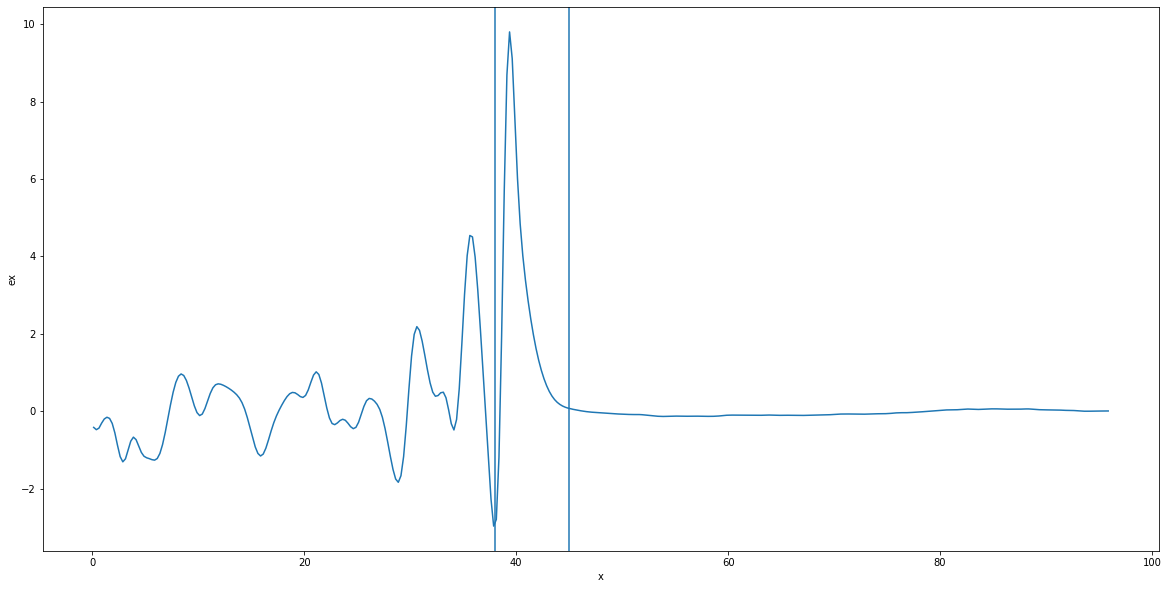

In [40]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 38.#lower bound for metadata = 1 (di)
endval = 45. #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [42]:
metadata = md.build_metadata(dfields, startval, endval)

In [43]:
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Test super plot

In [49]:
x1 = 28.
x2 = 29.
y1 = 0.
y2 = 1.
z1 = 0.
z2 = 1.
vmax = 15.
dv = .25

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [51]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

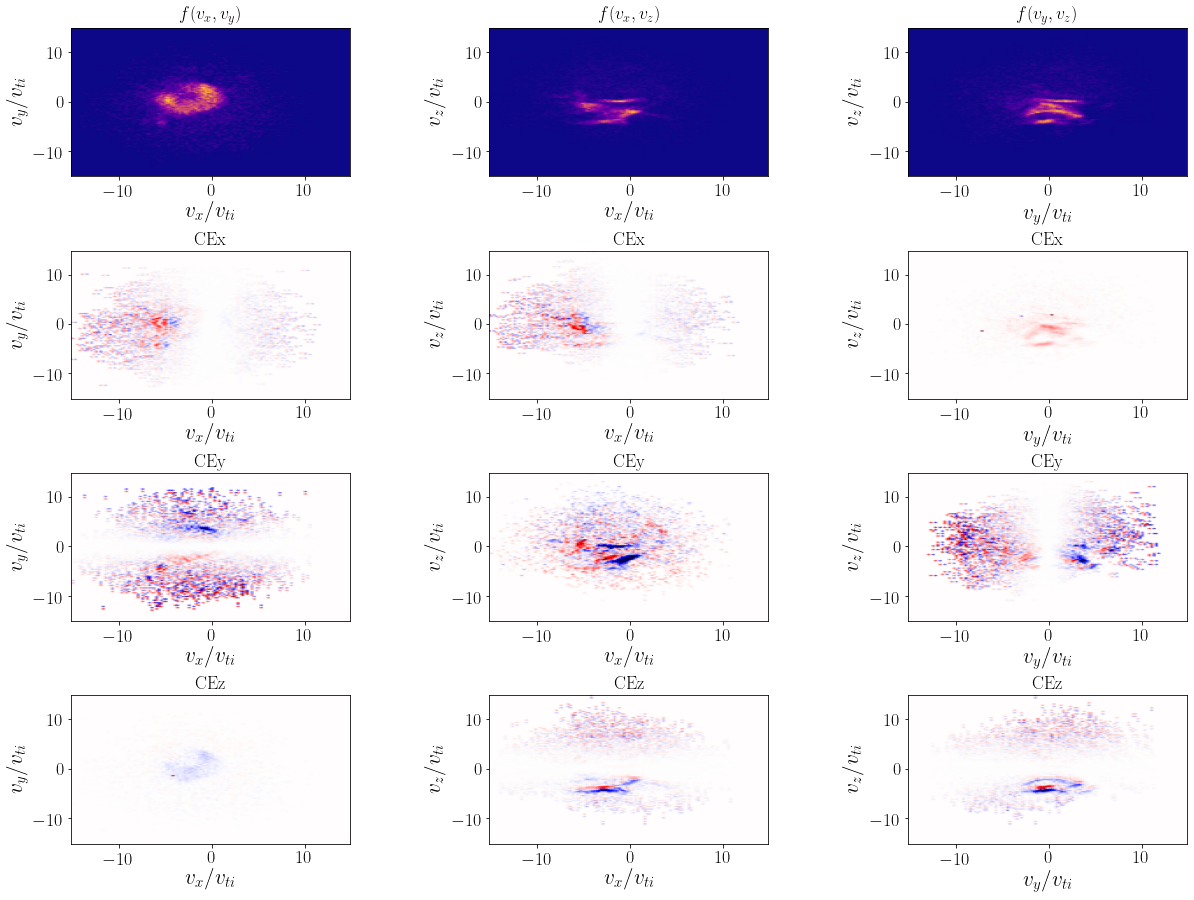

In [60]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [61]:
#Define parameters related to analysis
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0] #assumes rectangular grid thats uniform for all fields

In [ ]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock)

### Make superplot gif

In [ ]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

In [ ]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

### Convert to previous '2v FPC' formatting

In [ ]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_out = []
CEy_out = []
for i in range(0,len(CEx)):
    CEx_xy = af.threeCorToTwoCor(CEx[i],'xy')
    CEy_xy = af.threeCorToTwoCor(CEy[i],'xy')
    CEx_out.append(CEx_xy)
    CEy_out.append(CEy_xy)
    
vx_xy, vy_xy = af.threeVelToTwoVel(vx,vy,vz,'xy')
vx_out = vx_xy
vy_out = vy_xy
x_out = x

### Compute energization from correlations

In [ ]:
#TODO: project onto 2d plane and handle different projections net energization
enerCEx_out = af.compute_energization_over_x(CEx_out,dv)
enerCEy_out = af.compute_energization_over_x(CEy_out,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [ ]:
inputdict = svf.parse_input_file(path)

In [ ]:
params = svf.build_params(inputdict,numframe)

In [ ]:
inputdict

In [ ]:
params

In [ ]:
flnm = 'dHybridRSDAtest1newformatwithE.nc'
try:
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [ ]:
CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, metadata_in, params_in = svf.load_netcdf4(flnm)

### Make gif

In [ ]:
pf.make_velsig_gif(vx_in, vy_in, vmax, CEx_in, 'ex', x_out, 'CExframe1000', 'CExframe1000.gif')

<img src="CExframe1000.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif(vx_in, vy_in, vmax, CEy_in, 'ey', x_out, 'CEyframe1000', 'CEyframe1000.gif')

<img src="CEyframe1000.gif" width="750" align="center">

### Perform sanity checks
#### E cross B gif

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_out, 'ex', x_out, dx, dfields, 'CExFrame1000ExB', 'CExFrame1000ExB.gif')

<img src="CExFrame1000ExB.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_out, 'ey', x_out, dx, dfields, 'CEyFrame1000ExB', 'CEyFrame1000ExB.gif')

<img src="CEyFrame1000ExB.gif" width="750" align="center">

#### Energization vs J dot E

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

##  Plot fields as a function of time

In [ ]:
xxpltpoint = 20.0 #di
xxindex =  af.find_nearest(dfields['ex_xx'], xxpltpoint)
pf.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

## Test alternative get shock vel

In [ ]:
af.shockvel_from_compression_ratio(3)

In [ ]:
dM = 0.01
M = 1.1
shockvelarray = []
Minputarray = []
for k in range(0,1500):
    shockvelarray.append(af.shockvel_from_compression_ratio(M))
    Minputarray.append(M)
    M += dM
    
plt.figure()
plt.plot(Minputarray,shockvelarray)
plt.show()

In [ ]:
def shock(M):
    gamma = 5./3.
    return lambda v: 8./3.*(M-v)**2./(2./3.*(M-v)**2+2.)-M/v

from scipy.optimize import fsolve
fsolve(shock(3),2.)

In [ ]:
temparr = [1,2,3]
temparr = np.asarray(temparr)
temparr

In [ ]:
temparr += 3

In [ ]:
temparr

### Test version management

In [ ]:
##TODO: version management by saving git HEAD to netcdf4 file
#os.system('git rev-parse HEAD')

import subprocess

#https://stackoverflow.com/questions/34285796/python-execute-command-and-get-output
proc = subprocess.Popen(['git', 'rev-parse', 'HEAD'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(str(tmp)[2:-3]) #TODO: save this to netcdf4 file (edit save and load functions)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [ ]:
sanf.get_abs_max_velocity(dparticles)

### Test making field pmesh

In [ ]:
xxindex = 164
pf.makefieldpmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
pf.makefieldpmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

### Test 2d fourier

In [ ]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(lf)
importlib.reload(af)
importlib.reload(pf)
importlib.reload(svf)
importlib.reload(sanf)
importlib.reload(ftf)

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pf.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

In [ ]:
1/(2*np.k0

In [ ]:
for i in range(0,len(xplot)):
    for j in range(0,len(yplot)):
        print('x: ' + str(xplot[i][j]) + ' y: ' + str(yplot[i][j]) + ' pmesh: ' + str(fieldpmesh[i][j]))

In [ ]:
for i in range(0,len(xplot)):
    for j in range(0,len(yplot)):
        if(xplot[i][j] == yplot[i][j]):
            print('x: ' + str(xplot[i][j]) + ' y: ' + str(yplot[i][j]) + ' pmesh: ' + str(fieldpmesh[i][j]))

In [ ]:
arr = []
for i in range(0,len(yplot)):
    row = []
    for j in range(0,len(yplot[i])):
        row.append(0.)
    arr.append(row)
arr = np.asarray(arr)

In [ ]:
for i in range(0,len(xplot)):
    for j in range(0,len(xplot[i])):
        if(xplot[i][j] == xplot[0][3]):
            arr[i][j] = 1.

In [ ]:
arr[0][0] = 5.
arr[0][1] = 3.
arr[0][2] = 1.5
arr[1][0] = 4.
arr[0][4] = 10.

In [ ]:
plt.figure()
plt.contourf(xplot,yplot,arr)
plt.colorbar()
plt.show()

In [ ]:
arr[0]

In [ ]:
xplot[0]

In [ ]:
xplot

In [ ]:
yplot

In [ ]:
temparr = [[1,2,3],[4,5,6],[7,8,9]]
tempx = [[1,0,-1],[1,0,-1],[1,0,-1]]
tempy = [[1,1,1],[0,0,0],[-1,-1,-1]]
tempx = np.asarray(tempx)
tempy = np.asarray(tempy)
temparr = np.asarray(temparr)

In [ ]:
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

In [ ]:
np.argsort(tempx)

In [ ]:
np.sort(tempx)

In [ ]:
np.argsort(tempx)

In [ ]:
temparr[np.argsort(tempx)[0]][np.argsort(tempy)[:]]

In [ ]:
temprowx = tempx[0]
xsort = np.argsort(temprowx)
xsort

In [ ]:
tempcoly = tempy[:,0]
ysort = np.argsort(tempcoly)

In [ ]:
for i in range(0,len(temparr)):
    temparr[i] = temparr[i][xsort]
temparr

In [ ]:
temparr = temparr[ysort]

In [ ]:
temparr

In [ ]:
tempx = np.sort(tempx)
tempy = np.sort(tempy,axis=0)

In [ ]:
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

In [ ]:
np.sort(tempy,axis=0)

In [ ]:
#Test sorting 'double parallel' array
#need to sort tempx by row, sort tempy by column, and maintain same order with temparr

#build arrays
temparr = [[1,2,3],[4,5,6],[7,8,9]]
tempx = [[1,0,-1],[1,0,-1],[1,0,-1]]
tempy = [[1,1,1],[0,0,0],[-1,-1,-1]]
tempx = np.asarray(tempx)
tempy = np.asarray(tempy)
temparr = np.asarray(temparr)

#print before
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))
        
#sort        
temprowx = tempx[0]
xsort = np.argsort(temprowx)
tempcoly = tempy[:,0]
ysort = np.argsort(tempcoly)
for i in range(0,len(temparr)): #sort by col
    temparr[i] = temparr[i][xsort]
temparr = temparr[ysort] #sort by row
tempx = np.sort(tempx) #sort x data
tempy = np.sort(tempy,axis=0) #sort y data

#print after
print('-----after------')
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

In [ ]:
temparr = np.asarray([1,2,0.,3.])
np.where(temparr == 0)[0][0]

In [ ]:
temparr

### Estimate Ripple size

In [ ]:
pf.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

In [ ]:
pf.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)